### Test `Unseen Object Clustering (UCN)` Network

### Run the shell script of `UCN Network`

In [26]:
perception = "/home/terry/Rilab/sOftrobot/UnseenObjectClustering"

In [27]:
CAPTURE = True

import subprocess
import os

if CAPTURE:
    if os.path.exists(f"{perception}/label_data.npy"):
        os.remove(f"{perception}/label_data.npy")

    if os.path.exists(f"{perception}/depth_data.npy"):
        os.remove(f"{perception}/depth_data.npy")

    subprocess.run([f"cd {perception}; ./experiments/scripts/ros_seg_rgbd_add_test_segmentation_realsense.sh $GPU_ID 0"], shell=True)

+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ export CUDA_VISIBLE_DEVICES=0
+ CUDA_VISIBLE_DEVICES=0
+ outdir=data/checkpoints
+ ./ros/test_images_segmentation.py --gpu 0 --network seg_resnet34_8s_embedding --pretrained data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth --pretrained_crop data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth --cfg experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml


Called with args:
Namespace(background_name=None, cfg_file='experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml', dataset_name='shapenet_scene_train', gpu_id=0, instance_id=0, network_name='seg_resnet34_8s_embedding', pretrained='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', pretrained_crop='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', randomize=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'tabletop_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'INTRINSICS': [],
 'MODE': 'TRAIN',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/terry/Rilab/sOftrobot/UnseenObjectClustering',
 'TEST': {'AL

/home/terry/.local/lib/python3.8/site-packages/torch/nn/functional.py:4037: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/home/terry/.local/lib/python3.8/site-packages/torch/nn/functional.py:3982: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


3 objects
num_object 3


In [28]:
import numpy as np
label_pixel = np.load(f'{perception}/label_data.npy')
depth_pixel = np.load(f'{perception}/depth_data.npy') 

In [29]:
def Rotation_X(rad):
    roll = np.array([[1, 	       0, 	      0,    0],
             		 [0, np.cos(rad), -np.sin(rad), 0],
             		 [0, np.sin(rad),  np.cos(rad), 0],
             		 [0,		   0,	      0,    0]])
    return roll 


def Rotation_Y(rad):
    pitch = np.array([[np.cos(rad), 0, np.sin(rad), 0],
              		  [0,		    1, 	         0, 0],
              		  [-np.sin(rad),0, np.cos(rad), 0],
              		  [0, 		    0, 	         0, 0]])
    return pitch


def Rotation_Z(rad):
    yaw = np.array([[np.cos(rad), -np.sin(rad),  0, 0],
         	        [np.sin(rad),  np.cos(rad),  0, 0],
              		[0, 			         0,  1, 0],
             		[0, 			         0,  0, 0]])
    return yaw 

def Translation(x , y, z):
    Position = np.array([[0, 0, 0, x],
                         [0, 0, 0, y],
                         [0, 0, 0, z],
                         [0, 0, 0, 1]])
    return Position


def HT_matrix(Rotation, Position):
    Homogeneous_Transform = Rotation + Position
    return Homogeneous_Transform


In [30]:
import math

# Calibration
rotation_x   = Rotation_X(-math.pi)
rotation_y   = Rotation_Y(-math.pi/180*55)
rotation_mat = np.dot(rotation_x, rotation_y)

# camera_p = np.load("planned_traj/camera_p.npy")
camera_p = np.array([ 0.33107886, -0.25199999,  1.08883276])

position_mat = Translation(*(camera_p.tolist()))
transform_mat= HT_matrix(rotation_mat, position_mat)



In [37]:
def camera_to_base(transform_mat, points):
    ones = np.ones((len(points),1))
    points = np.concatenate((points,ones),axis=1)
    t_points = points.T
    t_transformed_ponints = np.dot(transform_mat,t_points)
    transformed_ponints = t_transformed_ponints.T
    xyz = transformed_ponints[:,0:3]
    return xyz

In [ ]:
def clean_point_cloud(single_cluster):
    # assume point_cloud is the point cloud as a numpy array with shape (n_points, 3)

    single_cluster = single_cluster[:,:3]
    # calculate the median of each dimension
    medians = np.median(single_cluster, axis=0)

    # calculate the median absolute deviation (MAD) of each dimension
    mad = np.median(np.abs(single_cluster - medians), axis=0)

    # set a threshold for outliers based on the MAD
    threshold = 3.0 * mad

    # calculate the distance of each point from the medians
    distances = np.abs(single_cluster - medians)

    # identify the outliers by comparing the distances to the threshold
    outliers = np.any(distances > threshold, axis=1)

    # remove the outliers from the point cloud
    cleaned_point_cloud = single_cluster[~outliers]
    return cleaned_point_cloud




In [38]:
clustering_num=len(np.unique(label_pixel));target_cluster_center_point=None;cluster_cen_pose_lst = []
# Total cluster loop
for cluster_idx in range(clustering_num):
    if cluster_idx ==0: continue

    # Random color 
    # color = random_color_gen()
    cluster_xlst, cluster_ylst = np.where(label_pixel==cluster_idx)

    clusters = []
    for idx, (x,y,z) in enumerate(zip(depth_pixel[2,cluster_xlst, cluster_ylst], \
                                        depth_pixel[0,cluster_xlst, cluster_ylst], \
                                        depth_pixel[1,cluster_xlst, cluster_ylst])):
        position=camera_to_base(transform_mat, np.array([[x,y,z]])).reshape(-1)
        clusters.append(position)

    break
        
single_cluster = np.stack(clusters)
cleaned_point_cloud = clean_point_cloud(single_cluster)

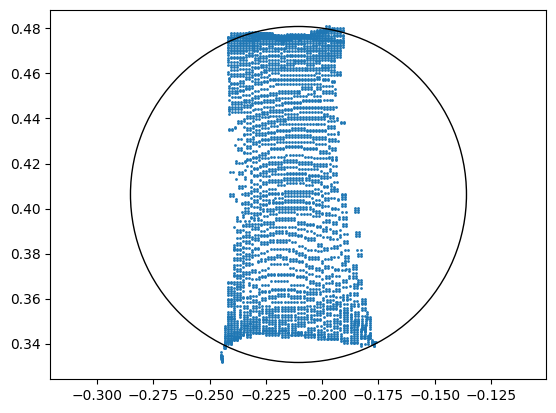

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

# project points onto the XY plane by ignoring the Z coordinate
projected_points = cleaned_point_cloud[:, [1,2]]

# compute extent of points in XY plane
min_x, min_y = np.min(projected_points, axis=0)
max_x, max_y = np.max(projected_points, axis=0)

# compute center of circle
center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

# compute radius of circle
radius = max((max_x - min_x), (max_y - min_y)) / 2

# plot the circle and points
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1)
circle = plt.Circle((center_x, center_y), radius, fill=False)
ax.add_artist(circle)

edge = 0.02
plt.xlim(center_x-radius-edge, center_x+radius+edge)
plt.ylim(center_y-radius-edge, center_y+radius+edge)
plt.axis('equal')
plt.show()


center_z = (min_y+max_y)/2

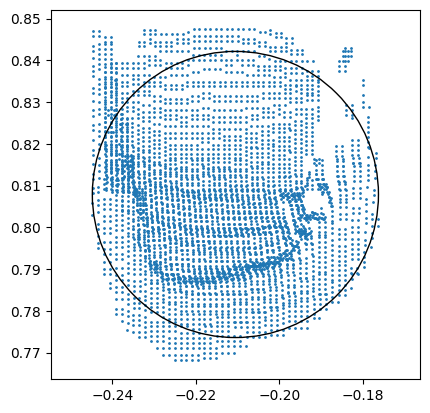

(-0.21049237103255622,
 0.8078729915235636,
 0.4062468358655133,
 0.034275693353265524)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

# project points onto the XY plane by ignoring the Z coordinate
projected_points = cleaned_point_cloud[:, [1,0]]

# compute extent of points in XY plane
min_x, min_y = np.min(projected_points, axis=0)
max_x, max_y = np.max(projected_points, axis=0)

# compute center of circle
center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

# compute radius of circle
radius = (max_x - min_x)/ 2
# plot the circle and points
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1)
circle = plt.Circle((center_x, center_y), radius, fill=False)
ax.add_artist(circle)

edge = 0.01
plt.xlim(center_x-radius-edge, center_x+radius+edge)
plt.ylim(center_y-radius-edge, center_y+radius+edge)
# plt.axis('equal')
plt.show()



# print(f"position_target:{position_target}")
center_position_array = np.array([center_x,center_y, center_z])

center_x, center_y, center_z, radius

In [49]:
center_position_array

array([-0.21049237,  0.80787299,  0.40624684])